In [1]:
class Event:
    def __init__(self, start, start_price, end, end_price, event_type, percentage_displacement=0):
        self.start = start
        self.start_price = start_price
        self.end = end
        self.end_price = end_price
        self.event_type = event_type
        self.overshoot = None
        self.percentage_displacement = percentage_displacement

class Type:
    Upturn = "Upturn"
    Downturn = "Downturn"
    UpwardOvershoot = "UpwardOvershoot"
    DownwardOvershoot = "DownwardOvershoot"

def generate_events(price_df, delta):
    events = []
    event = Type.Upturn

    last = Event(-1, 0, -1, 0, Type.Upturn)
    events.append(last)

    p_high = 0
    p_low = 0

    index_dc = [-1, -1]  # DC event indexes
    index_os = [-1, -1]  # OS event indexes
    index = 1

    for index, price in enumerate(price_df):
        if index == 0:
            p_high = price
            p_low = price

            index_dc = [index] * 2
            index_os = [index] * 2
        elif event == Type.Upturn:
            if price <= (p_high * (1 - delta)):
                last.overshoot = detect(price_df, Type.UpwardOvershoot, index_dc, index_os)


                adjust(last.overshoot if last.overshoot else last, index_dc, index_os)


                event = Type.Downturn
                p_low = price

                index_dc[1] = index
                index_os[0] = index + 1

                last = Event(index_dc[0], price_df.iloc[index_dc[0]], index_dc[1], price_df.iloc[index_dc[1]], Type.Downturn)
                events.append(last)

            elif p_high < price:
                p_high = price

                index_dc[0] = index
                index_os[1] = index - 1
        else:
            if price >= (p_low * (1 + delta)):
                last.overshoot = detect(price_df, Type.DownwardOvershoot, index_dc, index_os)



                adjust(last.overshoot if last.overshoot else last, index_dc, index_os)

                event = Type.Upturn
                p_high = price

                index_dc[1] = index
                index_os[0] = index + 1

                last = Event(index_dc[0], price_df.iloc[index_dc[0]], index_dc[1], price_df.iloc[index_dc[1]], Type.Upturn)
                events.append(last)

            elif p_low > price:
                p_low = price

                index_dc[0] = index
                index_os[1] = index - 1

    return events

def detect(price_df, event_type, index_dc, index_os):
    if index_os[0] < index_os[1] and index_os[0] < index_dc[0]:
        return Event(index_os[0], price_df.iloc[index_os[0]], index_os[1], price_df.iloc[index_os[1]], event_type)
    return None

def adjust(last, index_dc, index_os):
    if index_dc[0] == last.start:
        index_dc[0] = last.end + 1
    elif index_dc[0] > (last.end + 1):
        index_dc[0] = (last.end + 1)



In [2]:
import pandas as pd
phyisical_time_df = pd.read_csv('./USDJPY_10 Mins_Ask_2003.05.04_2024.03.29.csv')

In [3]:
price_df = phyisical_time_df["Close"]

In [4]:
import warnings

warnings.simplefilter('ignore')

threshold = 0.0025 #For confirmation

def output_dataframe_dc_os(price_df, threshold):

    events = generate_events(price_df, threshold)

    data = []

    for event in events:
        add_data = {
            "startIndexDC": int(event.start),
            "startPriceDC": event.start_price,
            "endIndexDC": int(event.end),
            "endPriceDC": event.end_price,
            "DC_type": event.event_type,
            "startIndexOS": int(event.overshoot.start) if event.overshoot else None,
            "startPriceOS": event.overshoot.start_price if event.overshoot else None,
            "endIndexOS": int(event.overshoot.end) if event.overshoot else None,
            "endPriceOS": event.overshoot.end_price if event.overshoot else None,
            "OS_type": event.overshoot.event_type if event.overshoot else None
        }
        data.append(add_data)

    df_dc_os = pd.DataFrame(data)

    df_dc_os = df_dc_os.iloc[1:]

    return df_dc_os


In [5]:
df_dc_os = output_dataframe_dc_os(price_df, threshold)

In [6]:
df_dc_os

,startIndexDC,startPriceDC,endIndexDC,endPriceDC,DC_type,startIndexOS,startPriceOS,endIndexOS,endPriceOS,OS_type
1,17,119.059,97,118.747,Downturn,98.0,118.896,424.0,116.380,DownwardOvershoot
2,425,116.259,460,116.581,Upturn,461.0,116.585,474.0,116.668,UpwardOvershoot
3,475,116.680,497,116.328,Downturn,498.0,116.351,532.0,116.121,DownwardOvershoot
4,533,116.061,540,116.460,Upturn,541.0,116.497,634.0,117.425,UpwardOvershoot
5,635,117.451,736,117.149,Downturn,737.0,117.127,790.0,116.578,DownwardOvershoot
...,...,...,...,...,...,...,...,...,...,...
15580,782620,151.076,782651,151.458,Upturn,782652.0,151.457,782663.0,151.453,UpwardOvershoot
15581,782664,151.483,782698,151.084,Downturn,NaN,NaN,NaN,NaN,None
15582,782699,151.143,782778,151.496,Upturn,782779.0,151.514,782986.0,151.874,UpwardOvershoot
15583,782987,151.898,783024,151.499,Downturn,783025.0,151.268,783037.0,151.142,DownwardOvershoot


In [7]:
df_dc_os

,startIndexDC,startPriceDC,endIndexDC,endPriceDC,DC_type,startIndexOS,startPriceOS,endIndexOS,endPriceOS,OS_type
1,17,119.059,97,118.747,Downturn,98.0,118.896,424.0,116.380,DownwardOvershoot
2,425,116.259,460,116.581,Upturn,461.0,116.585,474.0,116.668,UpwardOvershoot
3,475,116.680,497,116.328,Downturn,498.0,116.351,532.0,116.121,DownwardOvershoot
4,533,116.061,540,116.460,Upturn,541.0,116.497,634.0,117.425,UpwardOvershoot
5,635,117.451,736,117.149,Downturn,737.0,117.127,790.0,116.578,DownwardOvershoot
...,...,...,...,...,...,...,...,...,...,...
15580,782620,151.076,782651,151.458,Upturn,782652.0,151.457,782663.0,151.453,UpwardOvershoot
15581,782664,151.483,782698,151.084,Downturn,NaN,NaN,NaN,NaN,None
15582,782699,151.143,782778,151.496,Upturn,782779.0,151.514,782986.0,151.874,UpwardOvershoot
15583,782987,151.898,783024,151.499,Downturn,783025.0,151.268,783037.0,151.142,DownwardOvershoot


In [8]:
df_dc_os[df_dc_os["startIndexDC"] == df_dc_os["endIndexDC"]]

,startIndexDC,startPriceDC,endIndexDC,endPriceDC,DC_type,startIndexOS,startPriceOS,endIndexOS,endPriceOS,OS_type
15,1114,116.292,1114,116.292,Downturn,1115.0,116.231,1130.0,115.861,DownwardOvershoot
194,13635,117.261,13635,117.261,Upturn,13636.0,117.488,13772.0,117.520,UpwardOvershoot
581,34509,104.220,34509,104.220,Downturn,NaN,NaN,NaN,NaN,None
720,39042,114.230,39042,114.230,Upturn,39043.0,114.300,39052.0,114.550,UpwardOvershoot
1786,90683,113.336,90683,113.336,Upturn,90684.0,113.287,90751.0,114.200,UpwardOvershoot
...,...,...,...,...,...,...,...,...,...,...
14460,729634,147.441,729634,147.441,Upturn,729635.0,147.654,729692.0,149.423,UpwardOvershoot
14513,731594,141.774,731594,141.774,Downturn,731595.0,141.889,731596.0,141.709,DownwardOvershoot
14517,731630,140.540,731630,140.540,Downturn,NaN,NaN,NaN,NaN,None
14585,733629,138.634,733629,138.634,Downturn,733630.0,138.733,733640.0,137.736,DownwardOvershoot


In [9]:
def output_datafraome_classification(price_df, threshold):

    df_dc_os = output_dataframe_dc_os(price_df, threshold)

    df_classification = df_dc_os.copy()
    df_classification["PreviousOS"] = df_classification["OS_type"].shift(1)
    df_classification["PreviousOS"] = df_classification["PreviousOS"].apply(lambda x: 1 if x !=None else 0)
    df_classification["TimeDifference"] = (df_classification["endIndexDC"] - df_classification["startIndexDC"]) * 10
    df_classification["CurrentTmv"] = ((df_classification["endPriceDC"] - df_classification["startPriceDC"]) / df_classification["startPriceDC"]) / threshold
    df_classification["PreviousDCPrice"] = df_classification["endPriceDC"].shift(1)
    df_classification["Sigma"] = df_classification.apply(lambda x: (x["CurrentTmv"] * threshold) / x["TimeDifference"] if x["TimeDifference"] != 0 else -1, axis=1)
    df_classification["FlashEvent"] = df_classification.apply(lambda x: 1 if (x["endIndexDC"] == x["startIndexDC"]) else 0, axis=1)
    df_classification["IsOS"] = df_classification.apply(lambda x: 1 if x["OS_type"] != None else 0, axis=1)

    df_classification = df_classification.drop(columns=["startIndexDC", "startPriceDC", "endIndexDC", "endPriceDC", "DC_type", "startIndexOS", "startPriceOS", "endIndexOS", "endPriceOS", "OS_type"])

    df_classification = df_classification[1:]

    return df_classification

In [10]:
df_classification = output_datafraome_classification(price_df, threshold)

In [11]:
df_classification

,PreviousOS,TimeDifference,CurrentTmv,PreviousDCPrice,Sigma,FlashEvent,IsOS
2,1,350,1.107871,118.747,0.000008,0,1
3,1,220,-1.206719,116.581,-0.000014,0,1
4,1,70,1.375139,116.328,0.000049,0,1
5,1,1010,-1.028514,116.460,-0.000003,0,1
6,1,40,1.158424,117.149,0.000072,0,0
...,...,...,...,...,...,...,...
15580,1,310,1.011411,151.421,0.000008,0,1
15581,1,340,-1.053584,151.458,-0.000008,0,0
15582,0,790,0.934215,151.084,0.000003,0,1
15583,1,370,-1.050705,151.496,-0.000007,0,1


In [12]:
import numpy as np

def output_multi_thresholds_dataframe_classifiation(price_df, initial_threshold, max_threshold, num_threshold, search_step, min_ratio_is_os, max_ratio_is_os):
    min_max_threshold_list =[]
    thresholds_list = []
    dataframe_classification_list = []

    for threshold in np.arange(initial_threshold, max_threshold, search_step):
        df_classification = output_datafraome_classification(price_df, threshold)
        ratio_is_os = df_classification["IsOS"].sum() / len(df_classification)
        if min_ratio_is_os <= ratio_is_os:
            threshold_min_ration_is_os = threshold
            min_max_threshold_list.append(threshold_min_ration_is_os)
            print(f"Find the threshold {threshold_min_ration_is_os} for min_ratio_is_os")
            break
        else:
            continue

    for threshold in np.arange(max_threshold, initial_threshold, -search_step):
        df_classification = output_datafraome_classification(price_df, threshold)
        ratio_is_os = df_classification["IsOS"].sum() / len(df_classification)
        if ratio_is_os <= max_ratio_is_os:
            threshold_max_ration_is_os = threshold
            min_max_threshold_list.append(threshold_max_ration_is_os)
            print(f"Find the threshold {threshold_max_ration_is_os} for max_ratio_is_os")
            break
        else:
            continue

    print(f"Start the process from min_ratio_is_os to max_ratio_is_os")
    print(f"threshold_min_ration_is_os: {min_max_threshold_list[0]} to threshold_max_ration_is_os: {min_max_threshold_list[1]} by {num_threshold} steps")

    for step, threshold in enumerate(np.arange(min_max_threshold_list[0], min_max_threshold_list[1], (min_max_threshold_list[1] - min_max_threshold_list[0]) / num_threshold)):
        df_classification = output_datafraome_classification(price_df, threshold)
        thresholds_list.append(threshold)
        dataframe_classification_list.append(df_classification)
        if (step + 1)%5 == 0:
            print(f"step: {step + 1} / {num_threshold}")

    return thresholds_list, dataframe_classification_list




In [13]:
#selecting thresholds to obtain balanced data.
thresholds_list, dataframe_classification_list = output_multi_thresholds_dataframe_classifiation(price_df=price_df,
                                                                                                initial_threshold=0.0001,
                                                                                                max_threshold=0.01,
                                                                                                num_threshold=100,
                                                                                                search_step=0.000025,
                                                                                                min_ratio_is_os=0.4,
                                                                                                max_ratio_is_os=0.6) 

Find the threshold 0.00047499999999999994 for min_ratio_is_os
Find the threshold 0.0011749999999997474 for max_ratio_is_os
Start the process from min_ratio_is_os to max_ratio_is_os
threshold_min_ration_is_os: 0.00047499999999999994 to threshold_max_ration_is_os: 0.0011749999999997474 by 100 steps
step: 5 / 100
step: 10 / 100
step: 15 / 100
step: 20 / 100
step: 25 / 100
step: 30 / 100
step: 35 / 100
step: 40 / 100
step: 45 / 100
step: 50 / 100
step: 55 / 100
step: 60 / 100
step: 65 / 100
step: 70 / 100
step: 75 / 100
step: 80 / 100
step: 85 / 100
step: 90 / 100
step: 95 / 100
step: 100 / 100


In [14]:
dataframe_classification_list[0] #For confirmation

,PreviousOS,TimeDifference,CurrentTmv,PreviousDCPrice,Sigma,FlashEvent,IsOS
2,1,40,1.151172,118.973,0.000014,0,1
3,1,50,-1.291128,118.937,-0.000012,0,1
4,1,10,1.471270,118.958,0.000070,0,0
5,0,40,-1.435068,118.849,-0.000017,0,0
6,0,0,0.000000,118.747,-1.000000,1,0
...,...,...,...,...,...,...,...
131734,0,20,0.960265,151.269,0.000023,0,1
131735,1,60,-1.028680,151.343,-0.000008,0,1
131736,1,90,1.001731,151.372,0.000005,0,0
131737,0,0,0.000000,151.389,-1.000000,1,1


In [15]:
from pycaret.classification import *

setup_data = setup(data=dataframe_classification_list[49], categorical_features=["PreviousOS", "FlashEvent"],
                   numeric_features= ["PreviousDCPrice", "TimeDifference", "CurrentTmv", "Sigma"],
                   target="IsOS", use_gpu=True, normalize_method="zscore", session_id=123)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Description,Value
0,Session id,123
1,Target,IsOS
2,Target type,Binary
3,Original data shape,"(74457, 7)"
4,Transformed data shape,"(74457, 7)"
5,Transformed train set shape,"(52119, 7)"
6,Transformed test set shape,"(22338, 7)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

In [16]:
compare_result = compare_models(sort="precision", verbose=True)

In [17]:
gbc = create_model("gbc")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5829,0.6072,0.6821,0.5840,0.6293,0.1590,0.1615
1,0.5535,0.5773,0.6558,0.5596,0.6039,0.0997,0.1013
2,0.5798,0.6083,0.6961,0.5792,0.6323,0.1517,0.1552
3,0.5595,0.5881,0.6606,0.5646,0.6089,0.1117,0.1135
4,0.5719,0.5977,0.6917,0.5725,0.6265,0.1356,0.1389
5,0.5670,0.5927,0.6824,0.5691,0.6206,0.1258,0.1286
6,0.5698,0.5932,0.6728,0.5729,0.6188,0.1325,0.1347
7,0.5760,0.5995,0.6754,0.5783,0.6231,0.1451,0.1474
8,0.5691,0.5945,0.6766,0.5718,0.6198,0.1305,0.1330


In [18]:
gbc_tuned = tune_model(gbc)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5883,0.6101,0.7242,0.5832,0.6461,0.1674,0.1730
1,0.5551,0.5778,0.6987,0.5569,0.6198,0.0998,0.1036
2,0.5748,0.6083,0.7364,0.5700,0.6426,0.1385,0.1455
3,0.5595,0.5878,0.6983,0.5607,0.6220,0.1090,0.1129
4,0.5712,0.6000,0.7316,0.5674,0.6391,0.1312,0.1377
5,0.5708,0.5920,0.7268,0.5676,0.6374,0.1307,0.1368
6,0.5650,0.5941,0.7068,0.5647,0.6278,0.1201,0.1245
7,0.5731,0.5991,0.7105,0.5713,0.6334,0.1367,0.1414
8,0.5660,0.5923,0.7177,0.5645,0.6320,0.1212,0.1265


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [19]:
#２値ラベルがほぼ50%ずつ存在するデータセットを使用した。
#Accuracy、F1が60%を超えていないため使用は不可能
#テクニカル指標をデータセットに追加することも検討する必要がある

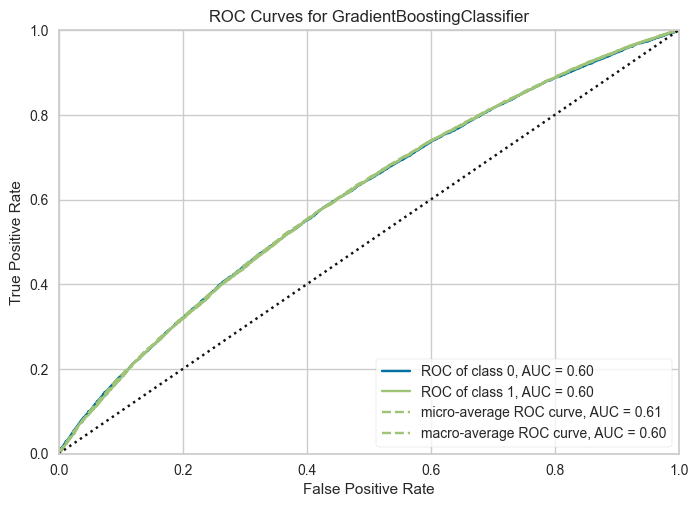

In [20]:
plot_model(gbc_tuned, plot = 'auc')

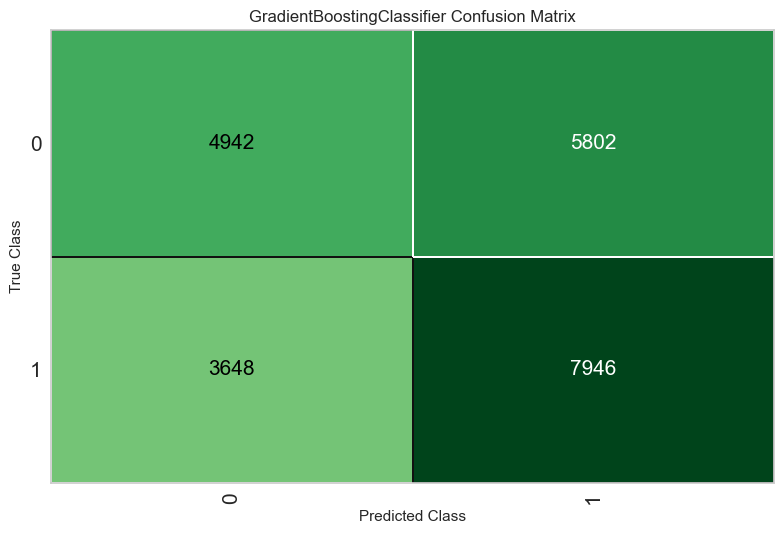

In [21]:
plot_model(gbc_tuned, plot = 'confusion_matrix')